<a href="https://colab.research.google.com/github/Dhaarani13/Project/blob/main/mobilenetv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing the necessary libraries
import kagglehub
import os
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np
from tqdm import tqdm  # Progress bar for large datasets
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.models import load_model

In [ ]:
# Download latest version
path = kagglehub.dataset_download("grassknoted/asl-alphabet")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/asl-alphabet


In [ ]:
# Define paths for input and output directories
input_dir = "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/"  # Raw dataset path
output_dir = "/root/.cache/kagglehub/datasets/processed_asl_alphabet/"  # Processed dataset path

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Set target image dimensions (width, height)
IMG_SIZE = (100, 100)  # All images will be resized to 100x100 pixels

def preprocess_images(input_dir, output_dir):
    """
    Preprocess ASL alphabet images by resizing, converting to grayscale,
    thresholding, and normalizing.

    Args:
        input_dir: Path to directory containing raw images
        output_dir: Path to save processed images
    """
    # Loop through each category (A-Z, 0-9, etc.) with progress bar
    for category in tqdm(os.listdir(input_dir)):
        # Create full paths for input and output category directories
        category_path = os.path.join(input_dir, category)
        output_category_path = os.path.join(output_dir, category)

        # Skip if it's not a directory (like .DS_Store files)
        if not os.path.isdir(category_path):
            continue

        # Create output directory for this category
        os.makedirs(output_category_path, exist_ok=True)

        # Process each image in the category
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)

            # Read image using OpenCV
            img = cv2.imread(img_path)

            # Skip if image couldn't be loaded
            if img is None:
                continue

            # Resize image to target dimensions
            img = cv2.resize(img, IMG_SIZE)

            # Convert from BGR to grayscale (1 channel)
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Apply binary thresholding (127 threshold value)
            _, img_thresh = cv2.threshold(
                img_gray,
                127,
                255,
                cv2.THRESH_BINARY
            )

            # Normalizing pixel values to range [0, 1]
            img_normalized = img_thresh / 255.0

            # Convert back to 0-255 range
            img_to_save = (img_normalized * 255).astype(np.uint8)

            # Saving the processed image
            save_path = os.path.join(output_category_path, img_name)
            cv2.imwrite(save_path, img_to_save)

# Executing the preprocessing function
preprocess_images(input_dir, output_dir)

# Completion message
print("Preprocessing completed. Processed images saved in:", output_dir)

100%|██████████| 29/29 [07:11<00:00, 14.88s/it]

Preprocessing completed. Processed images saved in: /root/.cache/kagglehub/datasets/processed_asl_alphabet/


In [ ]:


# Define dataset path and hyperparameters
dataset_path = "/root/.cache/kagglehub/datasets/processed_asl_alphabet/"  # Path to ASL alphabet dataset
IMG_SIZE = 150  # Target image size (150x150 pixels)
NUM_CLASSES = 29  # 26 letters + space + del + nothing
BATCH_SIZE = 8   # Smaller batch size for memory efficiency

# Configuring aggressive data augmentation to prevent overfitting
datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values to [0,1]
    rotation_range=45,       # Random rotations up to 45 degrees
    width_shift_range=0.5,   # Random horizontal shifts up to 50% of width
    height_shift_range=0.5,  # Random vertical shifts up to 50% of height
    zoom_range=0.5,          # Random zooming up to 50%
    horizontal_flip=True,    # Random horizontal flipping
    validation_split=0.3     # 30% of data for validation
)

# Creating training data generator
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),  # Resizing the  images
    batch_size=BATCH_SIZE,
    class_mode='categorical',          # Multi-class classification
    subset='training'                  # Using training subset (70%)
)

# Creating validation data generator
val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'                # Using validation subset (30%)
)

train_generator.samples = int(train_generator.samples * 0.75)

# Loading pre-trained MobileNetV2 model (without top classification layer)
base_model = MobileNetV2(
    weights="imagenet",         # Use ImageNet pre-trained weights
    include_top=False,          # Exclude final classification layer
    input_shape=(IMG_SIZE, IMG_SIZE, 3)  # Input shape matching our images
)

# Building custom classifier head with regularization
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reducing spatial dimensions to 1D vector
x = Dense(256, activation='relu', kernel_regularizer=l2(0.02))(x)  # Regularizing dense layer
x = Dropout(0.6)(x)             # High dropout rate for regularization
x = Dense(NUM_CLASSES, activation='softmax')(x)  # Final classification layer

# Create complete model
model = Model(inputs=base_model.input, outputs=x)

# Compile model with conservative learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # Small LR for stable training
model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",  # Standard loss for multi-class
    metrics=["accuracy"]              # Track accuracy metric
)

# Train the model for limited epochs
EPOCHS = 10
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

# Save the trained model
model.save("sign_language_mobilenetv2.h5")

print("Model training complete and saved as 'sign_language_mobilenetv2.h5' 🎉")

Found 60900 images belonging to 29 classes.
Found 26100 images belonging to 29 classes.


<ipython-input-4-802151504809>:49: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7613/7613 ━━━━━━━━━━━━━━━━━━━━ 767s 94ms/step - accuracy: 0.1447 - loss: 6.3821 - val_accuracy: 0.3323 - val_loss: 2.7910
Epoch 2/10
7613/7613 ━━━━━━━━━━━━━━━━━━━━ 683s 90ms/step - accuracy: 0.4580 - loss: 2.0937 - val_accuracy: 0.4080 - val_loss: 2.5077
Epoch 3/10
7613/7613 ━━━━━━━━━━━━━━━━━━━━ 682s 90ms/step - accuracy: 0.5418 - loss: 1.7412 - val_accuracy: 0.4562 - val_loss: 2.3223
Epoch 4/10
7613/7613 ━━━━━━━━━━━━━━━━━━━━ 676s 89ms/step - accuracy: 0.5922 - loss: 1.5624 - val_accuracy: 0.4789 - val_loss: 2.2589
Epoch 5/10
7613/7613 ━━━━━━━━━━━━━━━━━━━━ 681s 89ms/step - accuracy: 0.6173 - loss: 1.4631 - val_accuracy: 0.4946 - val_loss: 2.2081
Epoch 6/10
7613/7613 ━━━━━━━━━━━━━━━━━━━━ 705s 93ms/step - accuracy: 0.6403 - loss: 1.3805 - val_accuracy: 0.5095 - val_loss: 2.1949
Epoch 7/10
7613/7613 ━━━━━━━━━━━━━━━━━━━━ 678s 89ms/step - accuracy: 0.6592 - loss: 1.3076 - val_accuracy: 0.4947 - val_loss: 2.3876
Epoch 8/10
7613/7613 ━━━━━━━━━━━━━━━━━━━━ 679s 89ms/step - accuracy: 0.6773 - lo

Model training complete and saved as 'sign_language_mobilenetv2.h5' 🎉


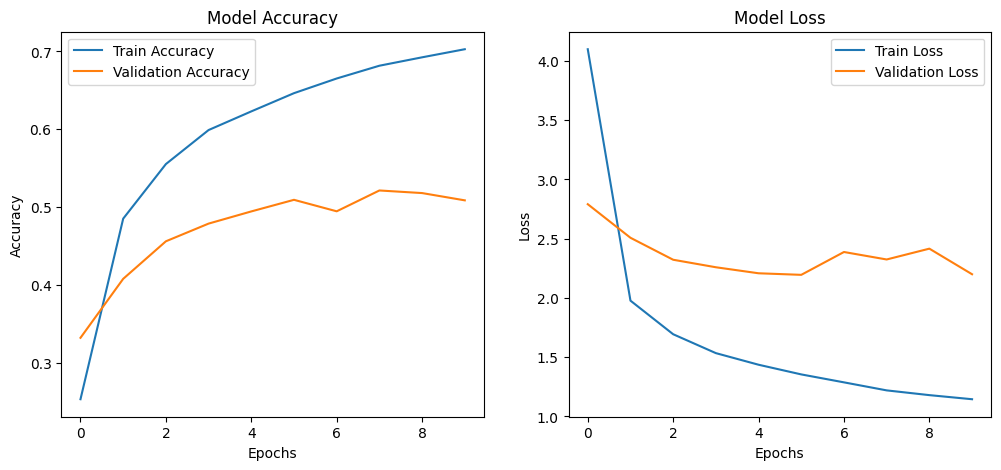

In [ ]:

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

Checking images in /root/.cache/kagglehub/datasets/processed_asl_alphabet/A
Found 3000 files in sample class folder
Found 87000 images belonging to 29 classes.
Found 87000 total images
10875/10875 ━━━━━━━━━━━━━━━━━━━━ 113s 10ms/step


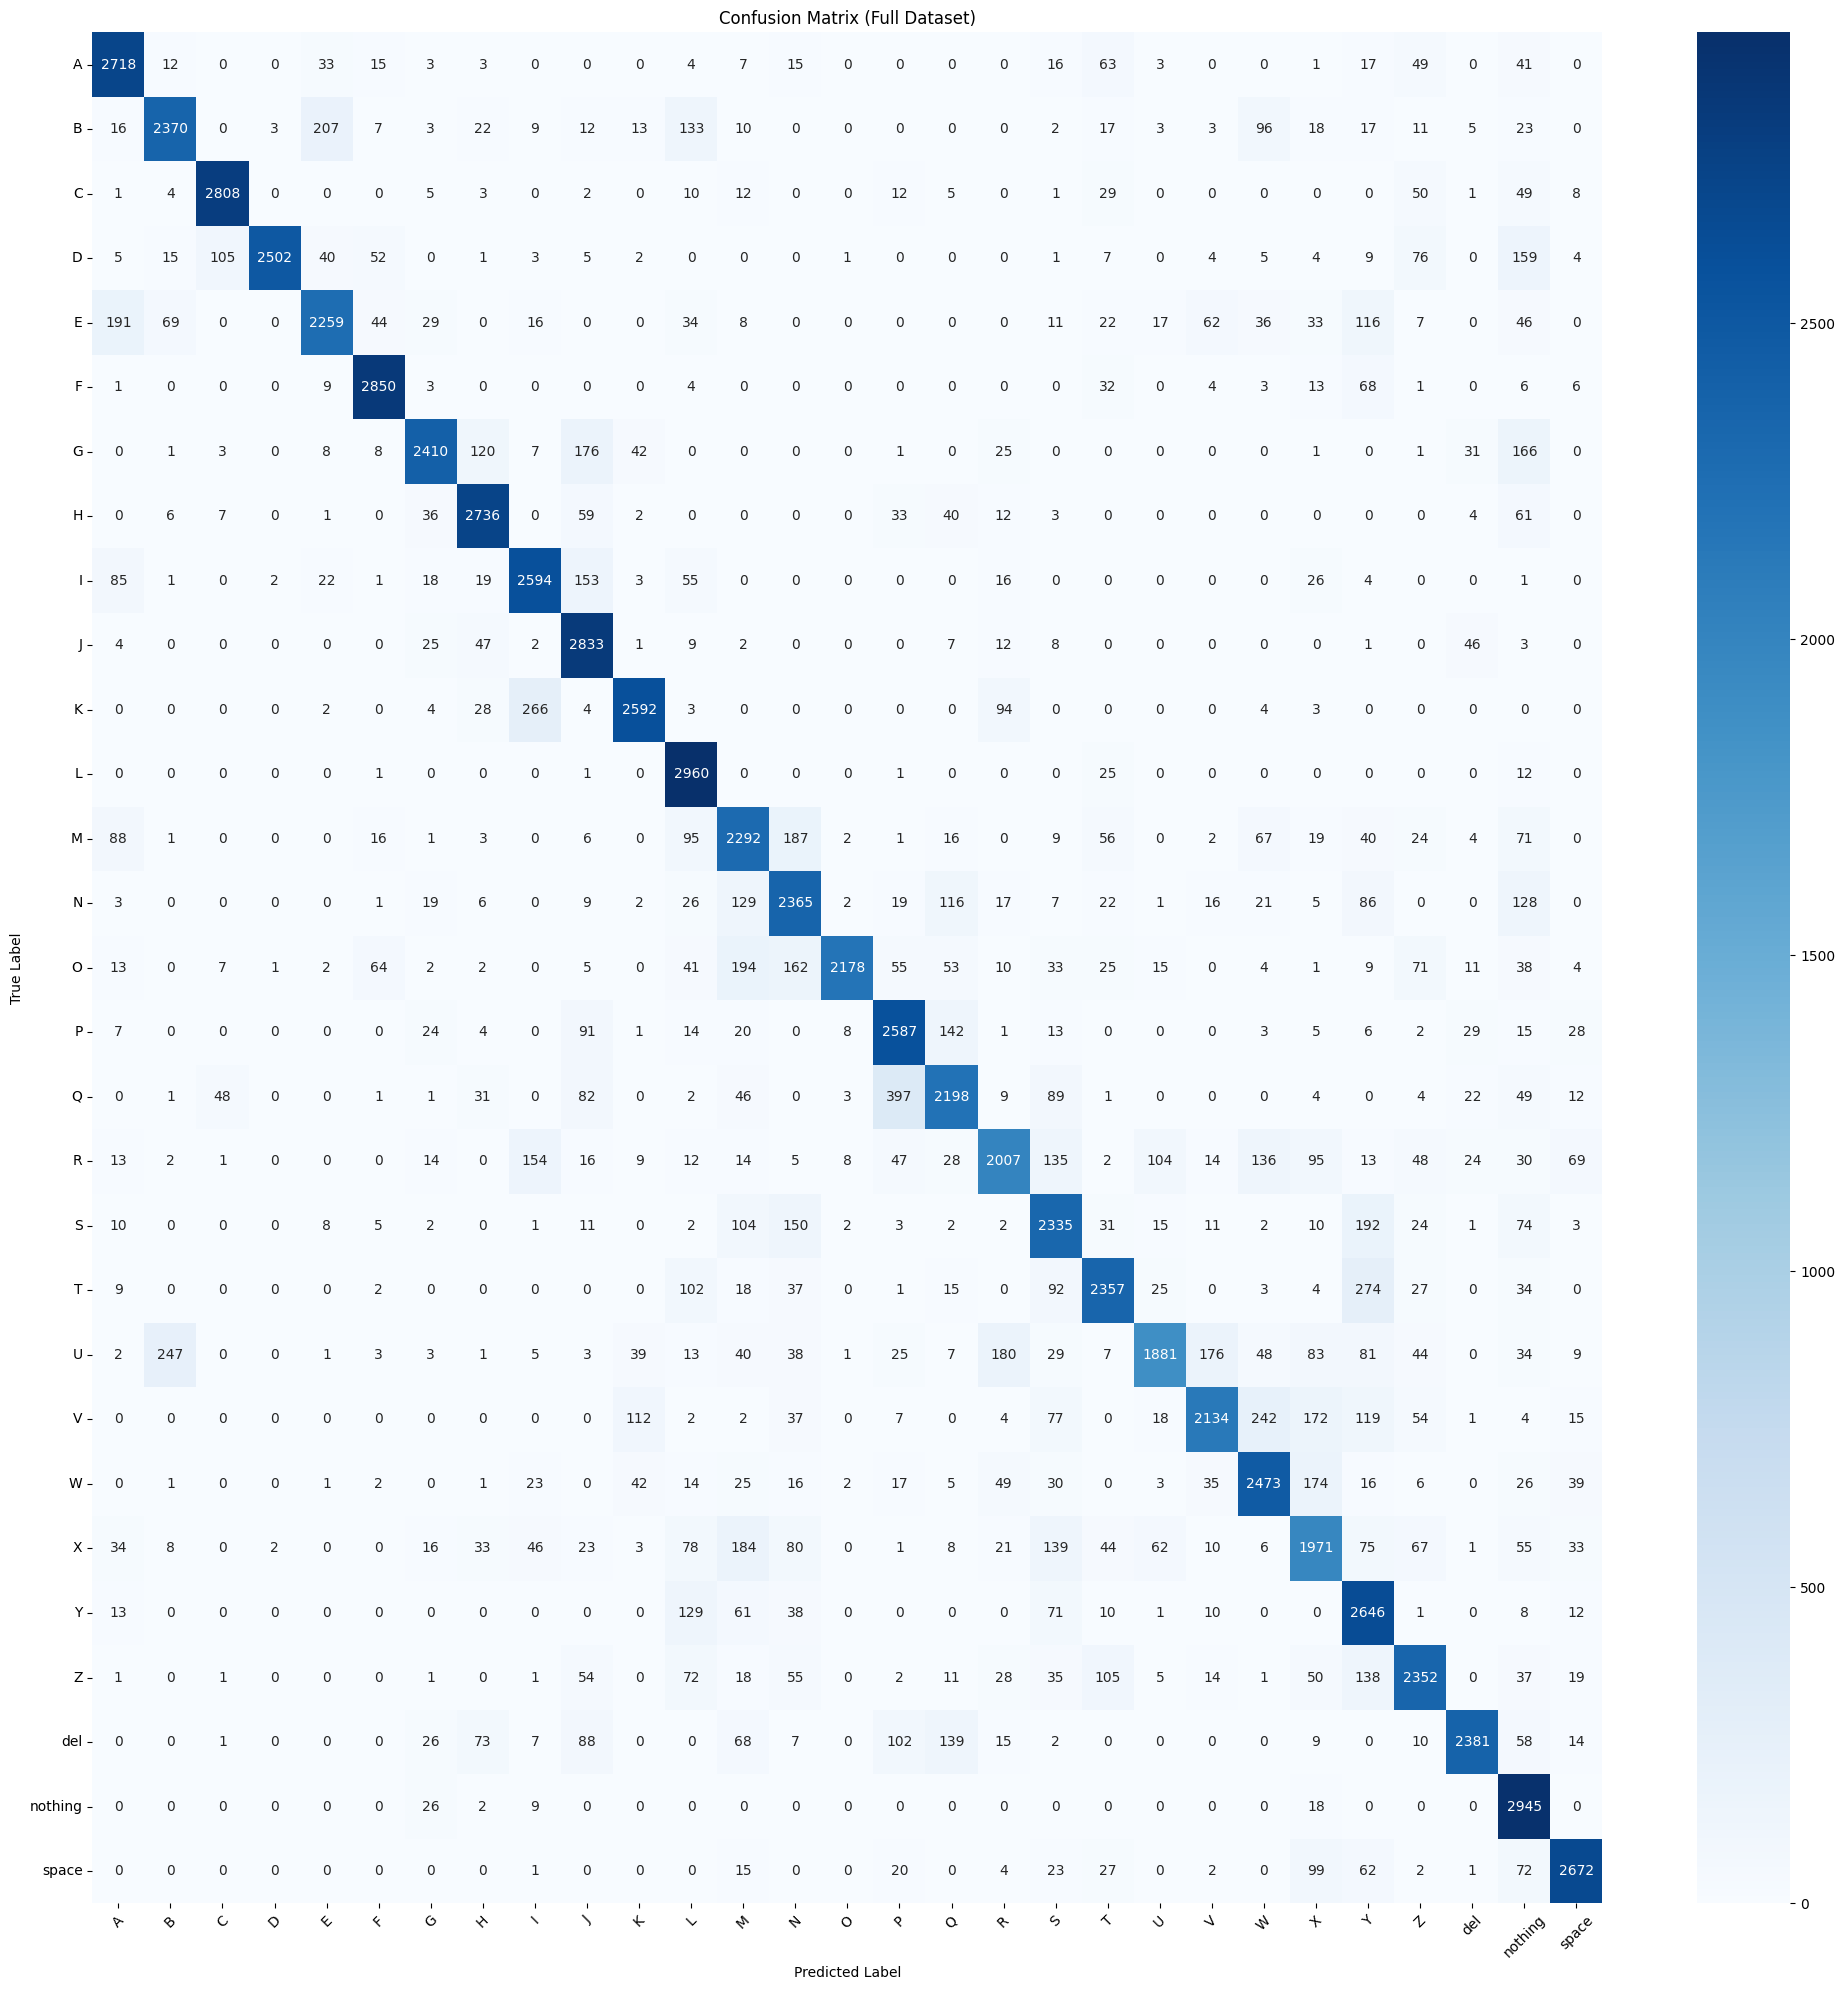


Classification Report:
              precision    recall  f1-score   support

           A       0.85      0.91      0.87      3000
           B       0.87      0.79      0.83      3000
           C       0.94      0.94      0.94      3000
           D       1.00      0.83      0.91      3000
           E       0.87      0.75      0.81      3000
           F       0.93      0.95      0.94      3000
           G       0.90      0.80      0.85      3000
           H       0.87      0.91      0.89      3000
           I       0.83      0.86      0.84      3000
           J       0.78      0.94      0.85      3000
           K       0.91      0.86      0.88      3000
           L       0.78      0.99      0.87      3000
           M       0.70      0.76      0.73      3000
           N       0.74      0.79      0.76      3000
           O       0.99      0.73      0.84      3000
           P       0.78      0.86      0.82      3000
           Q       0.79      0.73      0.76      3000
   

In [ ]:
# Load your trained model
model = load_model("sign_language_mobilenetv2.h5")

# Verify images exist in the folders
sample_class = 'A'  # Test with one class
sample_path = os.path.join(dataset_path, sample_class)
print(f"Checking images in {sample_path}")
print(f"Found {len(os.listdir(sample_path))} files in sample class folder")

# Solution 1: Try without validation split first
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Important for confusion matrix
)

if test_generator.samples == 0:
    raise ValueError("No images found at all! Check your dataset structure.")

print(f"Found {test_generator.samples} total images")

# Get predictions
y_true = test_generator.classes
y_pred = model.predict(test_generator, steps=len(test_generator))
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate confusion matrix
class_names = list(test_generator.class_indices.keys())
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix (Full Dataset)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix_full.png')
plt.show()

# Classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))